In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pandas import DataFrame
from datetime import datetime

from sklearn import preprocessing

In [2]:
# Set rnadom seed
tf.set_random_seed(77777)

In [3]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [4]:
# Hyper parameter
seq_length = 3
data_dim = 6 # Feature 개수
hidden_dim = 10
output_dim = 1
predict_day = 1 # 바로 다음 날
learning_rate = 0.01
iterations = 500
LSTM_stack = 1

In [5]:
pred_label = 3 # Timestamp,Open,High,Low,Close,Volume,Currency,Weighted Price => Close => 종가 예측

In [6]:
df = pd.read_csv('bitcoin.csv',delimiter=',', engine='python')
df = df.set_index('Date')
del df['Currency']

In [7]:
df.head()

,Open,High,Low,Close,Volume,Weighted Price
Date,,,,,,
2011-09-13,5.80,6.00,5.65,5.97,58.371382,5.929231
2011-09-14,5.58,5.72,5.52,5.53,61.145984,5.590798
2011-09-15,5.12,5.24,5.00,5.13,80.140795,5.094272
2011-09-16,4.82,4.87,4.80,4.85,39.914007,4.854515
2011-09-17,4.87,4.87,4.87,4.87,0.300000,4.870000


In [8]:
length = df.shape[0] # data lenght
length

2264

In [9]:
now = datetime.now()
year = now.year
month = now.month
day = now.day

for i in range(1,predict_day+1):
    df.loc[length+i] = df.iloc[length-1]
    df.index.values[length+i-1]= datetime(year, month, day+i-1)

In [10]:
df.tail()

,Open,High,Low,Close,Volume,Weighted Price
Date,,,,,,
2017-12-11,14690.99,17270.00,14677.19,16470.00,16583.723155,16293.316148
2017-12-12,16470.00,17428.42,15967.29,16650.01,13517.892103,16854.872561
2017-12-13,16650.01,17107.03,15497.69,16250.00,17136.705858,16434.926066
2017-12-14,16245.02,16494.94,15852.69,16270.61,3318.667206,16121.995504
2017-12-14 00:00:00,16245.02,16494.94,15852.69,16270.61,3318.667206,16121.995504


### Convert pandas df to nparray

In [11]:
dataset = df.as_matrix()
dataset

array([[  5.80000000e+00,   6.00000000e+00,   5.65000000e+00,
          5.97000000e+00,   5.83713824e+01,   5.92923065e+00],
       [  5.58000000e+00,   5.72000000e+00,   5.52000000e+00,
          5.53000000e+00,   6.11459836e+01,   5.59079751e+00],
       [  5.12000000e+00,   5.24000000e+00,   5.00000000e+00,
          5.13000000e+00,   8.01407952e+01,   5.09427191e+00],
       ..., 
       [  1.66500100e+04,   1.71070300e+04,   1.54976900e+04,
          1.62500000e+04,   1.71367059e+04,   1.64349261e+04],
       [  1.62450200e+04,   1.64949400e+04,   1.58526900e+04,
          1.62706100e+04,   3.31866721e+03,   1.61219955e+04],
       [  1.62450200e+04,   1.64949400e+04,   1.58526900e+04,
          1.62706100e+04,   3.31866721e+03,   1.61219955e+04]])

### MinMaxScaler

In [12]:
test_min = np.min(dataset, 0)
test_max = np.max(dataset, 0)
test_denom = test_max - test_min

print(test_min)
print(test_max)
print(test_denom)

dataset = MinMaxScaler(dataset)
dataset

[ 2.22        2.27        1.5         2.24        0.25        2.24035991]
[  16650.01         17428.42         15967.29         16650.01
  137070.17833806   16854.8725614 ]
[  16647.79         17426.15         15965.79         16647.77
  137069.92833806   16852.63220149]


array([[  2.15043558e-04,   2.14046132e-04,   2.59930764e-04,
          2.24054032e-04,   4.24027233e-04,   2.18889886e-04],
       [  2.01828591e-04,   1.97978326e-04,   2.51788355e-04,
          1.97624066e-04,   4.44269464e-04,   1.98807971e-04],
       [  1.74197296e-04,   1.70433515e-04,   2.19218717e-04,
          1.73596824e-04,   5.82846990e-04,   1.69345178e-04],
       ..., 
       [  1.00000000e+00,   9.81557028e-01,   9.70587112e-01,
          9.75972157e-01,   1.25019806e-01,   9.75081252e-01],
       [  9.75673047e-01,   9.46432230e-01,   9.92822153e-01,
          9.77210161e-01,   2.42096662e-02,   9.56512606e-01],
       [  9.75673047e-01,   9.46432230e-01,   9.92822153e-01,
          9.77210161e-01,   2.42096662e-02,   9.56512606e-01]])

In [13]:
dataset_temp = df.as_matrix()
test_last_X = (dataset_temp[-seq_length:,:]-test_min)/(test_denom+1e-7);
print(len(test_last_X))

test_last_X

3


array([[ 1.        ,  0.98155703,  0.97058711,  0.97597216,  0.12501981,
         0.97508125],
       [ 0.97567305,  0.94643223,  0.99282215,  0.97721016,  0.02420967,
         0.95651261],
       [ 0.97567305,  0.94643223,  0.99282215,  0.97721016,  0.02420967,
         0.95651261]])

### Build a dataset

In [14]:
dataX = []
dataY = []
dataY_temp = []
for i in range(0, len(dataset) - seq_length-predict_day+1):
    _x = dataset[i:i + seq_length]
    _y = dataset[i + predict_day:i + seq_length+predict_day]
    
    print(i + seq_length+predict_day) # i + 7 + 1
    
    dataX.append(_x)
    dataY.append(_y)
    

# train/test split 70 / 30
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
27

1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100


In [15]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim], name='intput_X')
Y = tf.placeholder(tf.float32, [None, 1], name='intput_Y')

# build a LSTM network
def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(hidden_dim, state_is_tuple=True) 
    return cell

multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(LSTM_stack)], state_is_tuple=True)


outputs_rnn, _states=tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)

In [16]:
X_for_fc = tf.reshape(outputs_rnn, [-1, hidden_dim])
Y_pred_temp = tf.contrib.layers.fully_connected(X_for_fc, output_dim, activation_fn=None)  
# reshape out for sequence_loss
Y_pred = tf.reshape(Y_pred_temp, [-1, seq_length])

Y_pred.shape

TensorShape([Dimension(None), Dimension(3)])

### Define Cost & loss fn

In [17]:
# cost/loss
mean_loss = tf.reduce_sum(tf.square(Y_pred - Y), name='losses_sum')  # sum of the squares
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mean_loss)

trainY_label=trainY[:,[-1], pred_label]
testY_label=testY[:,[-1], pred_label]

trainY

array([[[  2.01828591e-04,   1.97978326e-04,   2.51788355e-04,
           1.97624066e-04,   4.44269464e-04,   1.98807971e-04],
        [  1.74197296e-04,   1.70433515e-04,   2.19218717e-04,
           1.73596824e-04,   5.82846990e-04,   1.69345178e-04],
        [  1.56176886e-04,   1.49201057e-04,   2.06691933e-04,
           1.56777755e-04,   2.89370596e-04,   1.55118507e-04]],

       [[  1.74197296e-04,   1.70433515e-04,   2.19218717e-04,
           1.73596824e-04,   5.82846990e-04,   1.69345178e-04],
        [  1.56176886e-04,   1.49201057e-04,   2.06691933e-04,
           1.56777755e-04,   2.89370596e-04,   1.55118507e-04],
        [  1.59180288e-04,   1.49201057e-04,   2.11076308e-04,
           1.57979117e-04,   3.64777312e-07,   1.56037351e-04]],

       [[  1.56176886e-04,   1.49201057e-04,   2.06691933e-04,
           1.56777755e-04,   2.89370596e-04,   1.55118507e-04],
        [  1.59180288e-04,   1.49201057e-04,   2.11076308e-04,
           1.57979117e-04,   3.64777312e-07,

### Train model

In [18]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Tensorboard
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./tensorflowlog", sess.graph)
    
    losslist = [];
    # Training step
    for i in range(iterations):
    
        _, step_loss = sess.run([optimizer, mean_loss], 
                                        feed_dict={X: trainX, 
                                                   Y: trainY_label})
        losslist = np.append(losslist, step_loss)
        


    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    
    # Predictions test
    prediction_test = sess.run(Y_pred, feed_dict={X: test_last_X.reshape(1, seq_length, data_dim)})

In [19]:
print("predictions ", end='')
print(prediction_test *test_denom[pred_label]+test_min[pred_label])

predictions [[ 11965.90136719  11376.71484375  12404.93066406]]


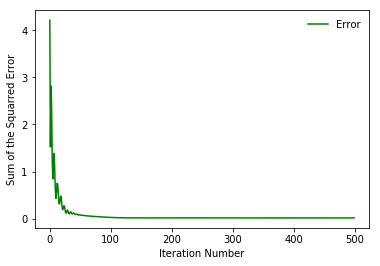

In [20]:
# Plot losss
plt.figure(1)
plt.plot(losslist, color="green", label="Error");
plt.xlabel("Iteration Number")
plt.ylabel("Sum of the Squarred Error")
plt.legend(loc='upper right', frameon=False)

plt.show()

In [21]:
predict_temp=(test_predict*test_denom[pred_label]+test_min[pred_label])
predict=np.empty((test_predict.shape[0]+seq_length-1 ,seq_length))
predict[:] = np.NAN
for i in range(0,seq_length):
    predict[i:test_predict.shape[0]+i,i]=predict_temp[:,i]
predict= DataFrame(predict.round())

In [22]:
Total_size=df.as_matrix().shape[0]
Predict_size=predict.shape[0]

predict_mean=predict.mean(axis =1)
Predict_close_concat=np.concatenate((np.zeros((Total_size-Predict_size,1))[:,-1],
                                     predict_mean), axis=0)

In [23]:
df["Predict Close"]=Predict_close_concat.round()

In [24]:
df.tail(100)

,Open,High,Low,Close,Volume,Weighted Price,Predict Close
Date,,,,,,,
2017-09-07,4605.81,4674.34,4475.00,4615.00,9254.851427,4585.198295,4223.0
2017-09-08,4615.00,4679.97,4125.99,4312.00,23693.301623,4371.253312,4251.0
2017-09-09,4327.41,4379.78,4164.00,4308.72,9974.388235,4279.895029,4082.0
2017-09-10,4322.44,4322.44,4010.00,4226.22,14724.204144,4145.585829,4025.0
2017-09-11,4226.21,4353.49,4092.40,4207.31,11191.595044,4212.891889,3908.0
2017-09-12,4198.89,4377.65,4080.00,4172.56,13294.437697,4232.449771,3940.0
2017-09-13,4170.60,4179.14,3720.01,3865.34,29636.380963,3897.807133,3922.0
2017-09-14,3861.89,3921.74,3210.00,3227.79,41319.397126,3535.911458,3690.0
2017-09-15,3227.79,3820.00,2972.01,3700.01,60278.946542,3370.470083,3375.0


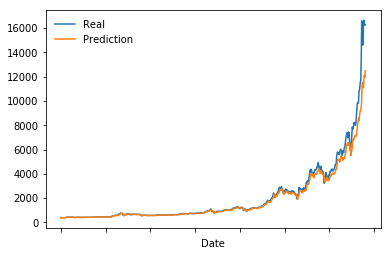

In [25]:
plt.figure(3)
df.iloc[Total_size-Predict_size:,3].plot(label="Real")
df.iloc[Total_size-Predict_size:,6].plot(label="Prediction")
plt.legend(loc='upper left', frameon=False)
plt.show()

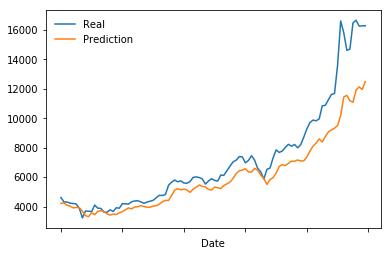

In [26]:
plt.figure(3)
df.iloc[-100:,3].plot(label="Real")
df.iloc[-100:,6].plot(label="Prediction")
plt.legend(loc='upper left', frameon=False)
plt.show()